# **Legal Grammar Error Corrector**
Code adapted from: https://huggingface.co/course/chapter7/3?fw=pt

## TODO List
Emily if you're reading this, you can skip to the final section on making predictions to see what output we get from the language model.

- TODO: (Isaac) Cleanup notebook.
- TODO: (Isaac): Convert to legal GEC. (In a separate notebook).
- TODO: (Isaac) Data Exploration
- TODO: (Emily): Writeup results.
- TODO: (BOTH): Compare related literature
- TODO: (BOTH): Write the rest of the writeup

In [1]:
!pip install transformers torch datasets evaluate numpy seaborn matplotlib
from transformers import AutoModelForMaskedLM
import torch
from datasets import load_dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set(context="poster")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [6]:
# Set the seed for reproducibility 
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "distilbert-base-cased"  # Retain uppercase
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"DistilBERT number of parameters: {round(distilbert_num_parameters)}M")
print(f"BERT number of parameters: 110M")

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

DistilBERT number of parameters: 66M
BERT number of parameters: 110M


## **The Data**

In [3]:
# from google.colab import files
# train_file = files.upload()
import sys
import os

from google.colab import drive
drive.mount("/content/drive")

dir_path = 'MyDrive/Colab Notebooks/LGEC'

env_path = f'/content/drive/{dir_path}'
print(os.listdir(env_path))

if env_path not in sys.path:
    sys.path.append(env_path)

train_file = f"{env_path}/Data/all_train.txt"
print(f"Reading {train_file}...")
with open(train_file, "r") as f:
    train_text = f.read().split("\n")

val_file = f"{env_path}/Data/all_val.txt"
print(f"Reading {val_file}...")
with open(val_file, "r") as f:
    val_text = f.read().split("\n")

test_file = f"{env_path}/Data/all_test.txt"
print(f"Reading {test_file}...")
with open(test_file, "r") as f:
    test_text = f.read().split("\n")


# Where our model output gets saved after training
save_path = f"{env_path}/model_outputs/BERT_trained_state_dict_cased.pt"

Mounted at /content/drive
['model_outputs', 'Data', 'runs', 'Presentation', 'Emily', 'corrector.ipynb', 'GPT_trainer.ipynb', 'BERT_trainer.ipynb']
Reading /content/drive/MyDrive/Colab Notebooks/LGEC/Data/all_train.txt...
Reading /content/drive/MyDrive/Colab Notebooks/LGEC/Data/all_val.txt...
Reading /content/drive/MyDrive/Colab Notebooks/LGEC/Data/all_test.txt...


In [5]:
# https://huggingface.co/docs/datasets/nlp_load
dataset = load_dataset("text", data_files={"train": train_file, "val": val_file, "test": test_file})
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-7292ef1cc9ebef0f/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 181632
    })
    val: Dataset({
        features: ['text'],
        num_rows: 24999
    })
    test: Dataset({
        features: ['text'],
        num_rows: 20409
    })
})

In [6]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


tokenized_datasets = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)
tokenized_datasets

  0%|          | 0/182 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 181632
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 24999
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 20409
    })
})

In [7]:
chunk_size = 128
def group_texts(samples):
    # Concatenate all texts
    concatenated_samples = {k: sum(samples[k], []) for k in samples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_samples[list(samples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_samples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [8]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

  0%|          | 0/182 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 43886
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 4704
    })
})

In [9]:
tokenizer.decode(lm_datasets["val"]["input_ids"][0])

'[CLS] " It was further provided that in case there was damage to the sugars in transit to Philadelphia preventing seller from making full delivery, seller was to deliver to each purchaser of sugar aboard that steamer a proportionate part of the sound packages. " [SEP] [CLS] The buyer\'s decision was to be given immediately upon advice of the seller that delay had occurred. [SEP] [CLS] " In the event of such cancellation by the buyer, the seller was to be under no further obligation under the contract. " [SEP] [CLS] The seller had on board the steamship West Cheswald sugars which before the end of September had been shipped on her from Java'

In [10]:
from transformers import DataCollatorForLanguageModeling
# What we use to mask over our training data
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

## **Training**
**Note:** We finetune the already trained BERT model by further training with our legal text document data.

In [11]:
from transformers import TrainingArguments

# Model Hyperparams
batch_size = 50
num_epochs = 10
learning_rate = 2e-5
weight_decay = 0.01

logging_steps = 50 * num_epochs
training_args = TrainingArguments(
    num_train_epochs=num_epochs,
    output_dir=f"{env_path}/model_outputs/",
    save_steps=5000,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=False,
    fp16=True,
)

In [12]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["val"],
    data_collator=data_collator,
)

Using cuda_amp half precision backend


In [13]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 43886
  Num Epochs = 10
  Instantaneous batch size per device = 50
  Total train batch size (w. parallel, distributed & accumulation) = 50
  Gradient Accumulation steps = 1
  Total optimization steps = 8780
  Number of trainable parameters = 65812036
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method

Step,Training Loss,Validation Loss
500,2.469600,2.162613
1000,2.296200,2.082561
1500,2.189300,2.011871
2000,2.138800,1.984763
2500,2.102700,1.965364
3000,2.068700,1.940416
3500,2.044200,1.923202
4000,2.024900,1.897017
4500,2.004700,1.890542
5000,1.977300,1.869052


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6259
  Batch size = 50
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6259
  Batch size = 50
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6259
  Batch size = 50
The following columns in the evaluati

TrainOutput(global_step=8780, training_loss=2.0517651464510074, metrics={'train_runtime': 2475.0684, 'train_samples_per_second': 177.312, 'train_steps_per_second': 3.547, 'total_flos': 1.454343291119616e+16, 'train_loss': 2.0517651464510074, 'epoch': 10.0})

In [14]:
# Plotting the training and validation loss.
# Note: This is quite a hacky way to do it but it works!
train_loss = []
val_loss = []
for idx, item in enumerate(trainer.state.log_history[:-1]):
    try:
        train_loss.append(item["loss"])
    except KeyError:
        try: 
            val_loss.append(item["eval_loss"])
        except KeyError:
            pass

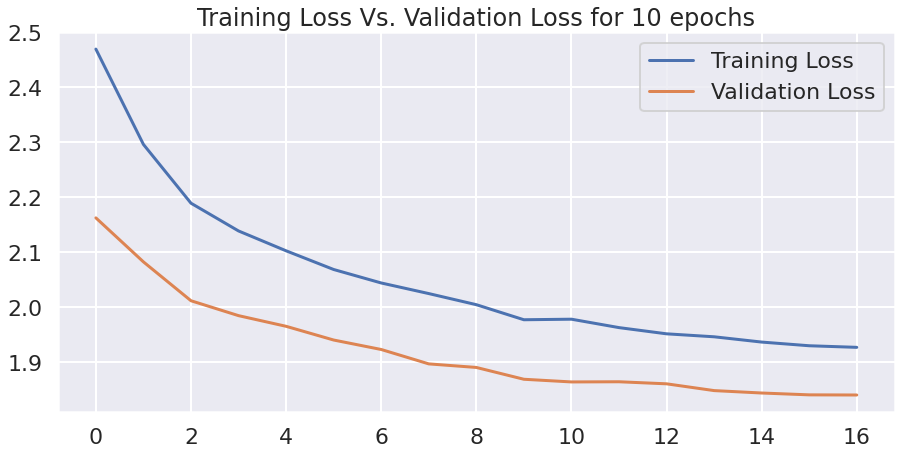

In [15]:
fig, ax = plt.subplots(figsize=(15, 7))
g = sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=ax, label="Training Loss")
g = sns.lineplot(x=range(len(train_loss)), y=val_loss, ax=ax, label="Validation Loss")
plt.title(f"Training Loss Vs. Validation Loss for {num_epochs} epochs")
plt.show()

In [16]:
eval_results = trainer.evaluate()
print(f"Perplexity after fine-tuning: {math.exp(eval_results['eval_loss']):.2f}")

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6259
  Batch size = 50


Perplexity after fine-tuning: 6.25


In [18]:
torch.save(model.state_dict(), save_path)

## **Evaluating Results**
Metrics:
- Top 1 accuracy
- Top 3 accuracy
- Training loss Vs. Validation loss plot
- Perplexity

Evaluated on validation set, then once all hyperparams set, tested on test set.

## Loading the Base Model

In [12]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
model_checkpoint = "distilbert-base-cased"
# Load the stock model
base_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_model = base_model.to(device)

## Loading our Fine-tuned Model

In [7]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
model_checkpoint = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint).to(device)
model.load_state_dict(torch.load(save_path, map_location=torch.device(device)))
model.eval()


DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inp

## **Accuracy**

In order to evaluate our fine-tuned masked language model compared to stock distilbert, we define the top k accuracy metric, which takes in a Dataset (i.e our validation or test dataset), and then returns the percentage of masked sentences for which our model predicted the masked word correctly within the top k suggestions (most probable words according to our model).

In [21]:
softmax = torch.nn.Softmax(dim=2)

def get_num_correct(batch_inputs, batch_outputs, batch_labels, k):
    mask_idx = torch.where(batch_inputs == 103)
    for idx in mask_idx:
        idx = idx.to(device)
    # Get probability distribution over vocab for masked words
    prob = softmax(batch_outputs.logits)[mask_idx]
    y_true = batch_labels[mask_idx]
    p, y_pred = torch.topk(prob, dim=1, k=k)
    num_correct = torch.count_nonzero(torch.sum(torch.isin(y_pred, y_true), dim=1))
    total_num_masks = mask_idx[0].size(0)
    return num_correct, total_num_masks


def top_k_accuracy(model, dataset, k, batch_size=5):
    labels = torch.tensor(dataset["labels"]).to(device)
    inputs = data_collator(dataset["input_ids"])["input_ids"].to(device)
    total_num_masks = 0
    total_num_correct = 0
    for i in range(0, inputs.size(0), batch_size):
        print("--------------------------------------------------")
        print(f"Calculating outputs: {i} / {inputs.size(0)}")
        batch_inputs = inputs[i:i+batch_size, :]
        batch_labels = labels[i:i+batch_size, :]
        with torch.no_grad():
            batch_outputs = model(batch_inputs)
        num_correct, total_batch_num_masks = get_num_correct(batch_inputs, batch_outputs, batch_labels, k)
        print(f"Num correct in k={k}: {num_correct} / {total_batch_num_masks}")
        print(f"Batch accuracy: {num_correct / total_batch_num_masks}")
        total_num_correct += num_correct
        total_num_masks += total_batch_num_masks
        print(f"Running Accuracy: {total_num_correct} / {total_num_masks} = {total_num_correct / total_num_masks}")

    return total_num_correct, total_num_masks

In [22]:
accuracy_dict = {"stock": {"val": {}, "test": {}}, "tuned": {"val": {}, "test": {}}}
model_dict = {"stock": base_model, "tuned": model}

model_name = "stock"
mode = "val"
for k in (1, 3):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(f">>>>>>>>>>>>> MODE: {mode} | MODEL: {model_name} | k={k} >>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    total_num_correct, total_num_masks = top_k_accuracy(base_model, lm_datasets[mode], k)
    accuracy = total_num_correct / total_num_masks
    accuracy_dict[model_name][mode][k] = accuracy

accuracy_dict

Streaming output truncated to the last 5000 lines.
--------------------------------------------------
Calculating outputs: 1260 / 6259
Num correct in k=3: 52 / 72
Batch accuracy: 0.7222222089767456
Running Accuracy: 12020 / 18373 = 0.6542208790779114
--------------------------------------------------
Calculating outputs: 1265 / 6259
Num correct in k=3: 54 / 79
Batch accuracy: 0.6835443377494812
Running Accuracy: 12074 / 18452 = 0.6543464064598083
--------------------------------------------------
Calculating outputs: 1270 / 6259
Num correct in k=3: 55 / 88
Batch accuracy: 0.625
Running Accuracy: 12129 / 18540 = 0.6542071104049683
--------------------------------------------------
Calculating outputs: 1275 / 6259
Num correct in k=3: 45 / 76
Batch accuracy: 0.5921052694320679
Running Accuracy: 12174 / 18616 = 0.6539535522460938
--------------------------------------------------
Calculating outputs: 1280 / 6259
Num correct in k=3: 49 / 73
Batch accuracy: 0.6712328791618347
Running Accurac

{'stock': {'val': {1: tensor(0.4261, device='cuda:0'),
   3: tensor(0.6447, device='cuda:0')},
  'test': {}},
 'tuned': {'val': {}, 'test': {}}}

In [23]:
model_name = "tuned"
mode = "val"
for k in (1, 3):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print(f">>>>>>>>>>>>> MODE: {mode} | MODEL: {model_name} | k={k} >>>>>>>>>>>>>")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    total_num_correct, total_num_masks = top_k_accuracy(model, lm_datasets[mode], k)
    accuracy = total_num_correct / total_num_masks
    accuracy_dict[model_name][mode][k] = accuracy

accuracy_dict

Streaming output truncated to the last 5000 lines.
--------------------------------------------------
Calculating outputs: 1260 / 6259
Num correct in k=3: 58 / 70
Batch accuracy: 0.8285714387893677
Running Accuracy: 15495 / 18334 = 0.8451510667800903
--------------------------------------------------
Calculating outputs: 1265 / 6259
Num correct in k=3: 50 / 61
Batch accuracy: 0.8196721076965332
Running Accuracy: 15545 / 18395 = 0.8450665473937988
--------------------------------------------------
Calculating outputs: 1270 / 6259
Num correct in k=3: 66 / 73
Batch accuracy: 0.9041095972061157
Running Accuracy: 15611 / 18468 = 0.845300018787384
--------------------------------------------------
Calculating outputs: 1275 / 6259
Num correct in k=3: 66 / 84
Batch accuracy: 0.785714328289032
Running Accuracy: 15677 / 18552 = 0.8450301885604858
--------------------------------------------------
Calculating outputs: 1280 / 6259
Num correct in k=3: 44 / 51
Batch accuracy: 0.8627451062202454
Runn

{'stock': {'val': {1: tensor(0.4261, device='cuda:0'),
   3: tensor(0.6447, device='cuda:0')},
  'test': {}},
 'tuned': {'val': {1: tensor(0.7069, device='cuda:0'),
   3: tensor(0.8443, device='cuda:0')},
  'test': {}}}

### Accuracy Results
```'stock': {'val': {1: 0.4261, 3: 0.6447}}, 'tuned': {'val': {1: 0.7069, 3: 0.8443}```

## **Perplexity**

In [24]:
from transformers import TrainingArguments
from transformers import Trainer
import math

def get_perplexity(model, eval_dataset):
    # Model Hyperparams
    batch_size = 50
    num_epochs = 30
    learning_rate = 2e-5
    weight_decay = 0.01
    logging_steps = 50 * num_epochs
    training_args = TrainingArguments(
        num_train_epochs=num_epochs,
        output_dir=f"{env_path}",
        overwrite_output_dir=False,
        evaluation_strategy="steps",
        logging_steps=logging_steps,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        push_to_hub=False,
        fp16=True,
    )
    eval_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=lm_datasets["train"],
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )
    eval_results = eval_trainer.evaluate()
    return math.exp(eval_results['eval_loss'])

In [25]:
print("--------------------------------------------------")
print(f"Perplexity for the base model, evaluated on the validation set: {get_perplexity(base_model, lm_datasets['val'])}")
print(f"Perplexity for our fine-tuned model, evaluated on the validation set: {get_perplexity(model, lm_datasets['val'])}")

# print("--------------------------------------------------")
# print(f"Perplexity for the base model, evaluated on the test set: {get_perplexity(base_model, lm_datasets['test'])}")
# print(f"Perplexity for our fine-tuned model, evaluated on the test set: {get_perplexity(model, lm_datasets['test'])}")

Using cuda_amp half precision backend
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6259
  Batch size = 50
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--------------------------------------------------


using `logging_steps` to initialize `eval_steps` to 1500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6259
  Batch size = 50


Perplexity for the base model, evaluated on the validation set: 29.75997578492637


Perplexity for our fine-tuned model, evaluated on the validation set: 6.24269411580098


### Perplexity Results
Perplexity for the base model, evaluated on the validation set: 29.75997578492637

Perplexity for our fine-tuned model, evaluated on the validation set: 6.24269411580098 

In [8]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [9]:

model.push_to_hub("distilbert-for-legal-grammar-error-correction")

CommitInfo(commit_url='https://huggingface.co/isaacjeffersonlee/distilbert-for-legal-grammar-error-correction/commit/c75c61c9f9c299184d3a466767c2b6d0b8277c53', commit_message='Upload DistilBertForMaskedLM', commit_description='', oid='c75c61c9f9c299184d3a466767c2b6d0b8277c53', pr_url=None, pr_revision=None, pr_num=None)